<a href="https://colab.research.google.com/github/pantelis-giankulidis/kervolutionalNN/blob/main/kervolutionalNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks with polynomial kernels
**Introduction**

Having been recently proposed,kervolutional neural networks use the kernel trick
in the convolution operation to achieve high dimension non-linear hyperplanes for classification. <a href='https://arxiv.org/pdf/1904.03955.pdf'>original paper</a>

Let's say that $f(x)= x \otimes w $ is the convolution between a $[N,C,H,W]$ tensor x, which represents a state of an image and a $[H_w,W_w,C_w]$ filter w.
In convolutions,we just multiply the two tensors elementwise and add them.In kervolutions, we instead apply the operation $f(x) = <\phi(x),\phi(w)>$,were $\phi$ is a higher dimensional representation of its input.By going into higher dimensions we can ,in general, capture more difficult relations and thus make more precise classifiactions.

Of course, we can avoid this computationally insufficient multiplication $f$ by applying the well-known in Machine Learning literature kernel trick

$<\phi(x),\phi(w)> = \sum_{j}c_j(x^{T}w)^{j}=k(x,w)$

where $k$ is a kernel function.In this work,we consider the polynomial kernel
$K(x,y)=(x^{T}y + c)^{d}$
where $c$ and $d$ are hyperparameters of the models.

**Experiment procedure**

The approach that's followed to find a suitable network architecture for neural networks having kervolutional layers, is the babysitting approach: about 7 to 10 initial different architectures are created and we try to improve performance on each of them.

The initial architectures are either naive shallow networks or traditional architectures, as AlexNet where the convolutional layers have been replaced with kervolutional layers.

State of the art normalization and optimization techniques are also applied, with the help of PyTorch,but there is no investigation of their impact on the network's performance.

\\

**Convolutional vs kervolutional networks performance**

The first assessment of kervolutional networks,is their behaviour in compare to convolutional networks with the same number of trainable parameters.That way,we value the impact of kervolutional layers on neural networks for image classification, regarding convergence and accuracy.

\\

**Impact of Relu**

Non-linearity of a traditional neural network is achieved by applying a non-linear activation function.The most popular for computer vision tasks, is the rectified linear unit (Relu) activation function.We value the impact of Relu unit when it is applied after a kervolutional layer and if its nonlinearity helps convergence.

\\

**Pooling layers in a kervolutional network**

As mentioned above,non-linearity can be achieved with the kernel trick during convolution, in a kervolutional layer.This means that pooling layers may not be of a positive impact.We value that,as well.

\\

**General assumptions and simplifications**

The following have been applied at every network that has been trained.


**a)** SGD optimization \\
**b)** Learning rate ${\eta}=e^{-2}$ \\
**c)** Kaiman Weight initialization


**Loading the datasets and data preprocessing**

In order to use the kervolutional layer implementation of <a href='https://github.com/wang-chen/kervolution'>wang-chen</a> for PyTorch,we have to add the project as a submodule to our project.After doing that,we can simply add a kervolutional layer with *nn.Kerv2d()* and use it as a regular PyTorch module component.  
To do so,the following script is executed:


In [ ]:
!git init
!git submodule add https://github.com/wang-chen/kervolution
!git add .
!git config --global user.email "pantelis.giankoulidis+1@gmail.com"
!git config --global user.name "pantelis-giankulidis"
!git commit -m "Initialization of the project"

The dataset that we will be using,is a subset of the ImageNet dataset,one of the most popular ones for computer vision.We are loading the simple *tiny-imagenet-200* dataset,containing images of 200 different classes,each one with 500 samples,for training. The test set contains 10000 images.



**Tiny imagenet**
Download the tiny imagenet and create the PyTorch corresponding dataset with the following script

In [ ]:
from google.colab import drive 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from PIL import Image
import os
import pandas as pd
import torch
import torchvision.transforms as trans
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)


#Download the tiny imagenet dataset from Stanford university and unzip it to Google drive 
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq './tiny-imagenet-200.zip'
#!rm './tiny-imagenet-200.zip'


#Load dataset with PyTorch for training
class tiny_imagenet_200_training_dataset(Dataset):
  def __init__(self,train_dir,transform=None):
    self.path = train_dir
    self.classes = os.listdir(train_dir)
    self.images = []
    self.classids = dict()
    classid=0

    for clas in self.classes:
      tmp_dir = os.path.join(self.path,clas,'images')
      self.classids[clas] = classid

      for img in os.listdir(tmp_dir):
        self.images.append((os.path.join(tmp_dir,img),classid))
      classid+=1

    self.transform = transform 

  def __len__(self):
    return len(self.images)

  def __getitem__(self,index):
    x,y = self.images[index]
    x = Image.open(x)
    
    #We transform Greyscale images to RGB images
    if isinstance(x.getpixel((4,5)),int):
      x1 = Image.new('RGB',x.size)
      data = zip(x.getdata(),x.getdata(),x.getdata())
      x1.putdata(list(data))
      x=x1
      
    
    if self.transform is not None:
      x = self.transform(x)
    
    return x,y


#The transform that we will be using in our experiments is mean subtraction.We hardcode the mean and std for every channel
transform = trans.Compose([trans.ToTensor(),
                           trans.Normalize((0.5,0.477,0.5),(0.2,0.29,0.24))])


#Load dataset with PyTorch for validation
class tiny_imagenet_200_val_dataset(Dataset):
  def __init__(self,val_dir,classids,transform=None):
    self.path = val_dir
    self.images = []
    with open(os.path.join(val_dir,'val_annotations.txt')) as val:
      for line in val:
        tmp = line.split("\t")
        self.images.append((os.path.join(val_dir,'images',tmp[0]),classids[tmp[1]]))
    self.transform = transform 

  def __len__(self):
    return len(self.images)

  def __getitem__(self,index):
    x,y = self.images[index]
    x = Image.open(x)

    if isinstance(x.getpixel((4,5)),int):
      x1 = Image.new('RGB',x.size)
      data = zip(x.getdata(),x.getdata(),x.getdata())
      x1.putdata(list(data))
      x=x1

    if self.transform is not None:
      x = self.transform(x)
    
    return x,y 

#Testing proper reading
train = tiny_imagenet_200_training_dataset('./tiny-imagenet-200/train',transform)
loader_train = DataLoader(train,batch_size=64,sampler=sampler.SubsetRandomSampler(range(100000)))
val = tiny_imagenet_200_val_dataset('./tiny-imagenet-200/val',train.classids,transform)
loader_val = DataLoader(val,batch_size=64,sampler=sampler.SubsetRandomSampler(range(10000)))

**Hardware** \
As it is common practice in neural network training,GPUs will be used instead of CPUs.No thoroughly investigation would be proceeded regarding the impact of kervolutional layers on CPU or GPU training,instead some common hardware choices would be made. \
Cuda GPU is going to be used with the default PyTorch settings.Later,with larger datasets,we will make some improvements.


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('using device: ',device)

using device:  cpu


**The training process** \
The training process that is to be followed is the standard for pytorch framework 

In [ ]:
#For simplicity and GPU usage efficiency,all values would be torch floats
dtype = torch.float32

#Checking accuracy every 10 batches to evaluate network's convergence
def check_accuracy(loader, model):
      
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return 100*acc

In [ ]:
def trainer(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    print_every = 100
    convergence = list()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # In PyTorch, we need to set the gradients to zero before starting to do backpropragation,
            # because PyTorch accumulates the gradients on subsequent backward passes. 
            # This is convenient while training RNNs but we dont' want this behaviour here.
            # Because of this, before we start the backpropagation, we set the gradients to zero
            # in order to do the parameter update correctly. Otherwise, the gradient would point in some other direction 
            # than the intended direction towards the minimum.
            optimizer.zero_grad()

            # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            if t>500:
              return convergence
              
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                convergence.append(check_accuracy(loader_val, model))
                print()

    return convergence

# **The experiments:A chaviar approach for best architectures**

During the first phase of our investigation for the correlation between network architecture and the kervolution operation,several existing ,successful for image recognition, network architectures are choosed,to which we make some layer adjustments,like replacing convolutional layers with kervolutional layers,or removing pooling layers.We create all these networks in parallel and in the end,the best of them,in validation accuracy and time performace would be picked as basis architectures for further investigation. \
An initial simplistic approach is to pick successful architectures that operate a convolution for feature extraction and replace the convolution layers with kervolution layers.Initially,we choose five different architectures for CNNs: \
**a)**A simple two layer network with one convolution layer,with 100 5X5 windows,and a fully connected layer. \
**b)**The LeNet architecture,with the necessary image preprocessing,since the classic LeNet takes,32X32X3 images and our Imagenet dataset provides 64X64X3 sized images. \
**c)**AlexNet,a much deeper than the latter architecture,with roughly 60 million parameters.A data preprocessing is needed here as well,so the network can take 64X64X3 images. \
**d)**Residual networks,recently proposed technique that allows training on very deep networks. \
**e)**Inception network for further investigating the impact of the window to the network's performance.  

All these architectures are implemeneted here,for convolution and kervolution networks,with many parameters adjustable so we can create slighly different newtorks to assess.


### **Two layer network**
A simplistic initial approach would be to train the dataset in a shallow network containing just one hidden,kervolutional layer,with or without Relu and a fully-connected layer afterwards.This way,we can have an initial sense of the difference between convolution and convolution with kernels,in a sense of performance and learning, and their impact in neural networks for computer vision tasks


In [ ]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import kervolution 

class TwoLayerKerv(nn.Module):
  #Suitable for 64x64 size images
  def __init__(self,hid_layer,window_size,num_classes,relu=True):
    super().__init__()
    padding = 1
    #Sole kervolutional layer with hid_layer filters of window_size x window_size x 3 size each
    size = 64 + 2*padding - window_size + 1
    self.hl = nn.Kerv2d(3,hid_layer,(window_size,window_size),padding=1)
    nn.init.kaiming_normal_(self.hl.weight)
    self.fc = nn.Linear(hid_layer*size*size,num_classes)
    nn.init.kaiming_normal_(self.fc.weight)
    self.relu = relu

  def forward(self,x):
    if self.relu:
      x = F.relu(self.hl(x))
    else:
      x = self.hl(x)

    x = x.view(x.shape[0],-1)
    
    return self.fc(x)
  

class TwoLayerConv(nn.Module):
  def __init__(self,hid_layer,window_size,num_classes,relu=True):
    super().__init__()
    padding = 1
    size = 64 + 2*padding - window_size + 1
    self.hl = nn.Conv2d(3,hid_layer,(window_size,window_size),padding=1)
    nn.init.kaiming_normal_(self.hl.weight)
    self.fc = nn.Linear(hid_layer*size*size,num_classes)
    nn.init.kaiming_normal_(self.fc.weight)
    self.relu = relu

  def forward(self,x):
    if self.relu:
      x = F.relu(self.hl(x))
    else:
      x = self.hl(x)

    x = x.view(x.shape[0],-1)
    return self.fc(x)

def test():
  x = torch.zeros((64,3,64,64))
  model = TwoLayerKerv(12,10)
  scores = model(x)
  print("We should see [64,10]  ",scores.size())

  x = torch.zeros((64,3,64,64))
  model = TwoLayerConv(12,10)
  scores = model(x)
  print("W eshould see [64,10]   ",scores.size())


### **LeNet**
We now take a classic successful CNN and change its conv layers with same size kerv layers while keeping all other hyperparameters and architecture the same.\
Note that LeNet takes greyscale images as input and it's not a good choice for RGB image classification like ImageNet images we are using.However,we make this experiments to have an initial sense of the correlation between architecture and kervolution.\
We train a classic LeNet and our kervolutional LeNet and compare the two networks. 

In [ ]:
class KervLeNet(nn.Module):
  def __init__(self,relu=True,pooling=True):
    super().__init__()
    self.kerv1 = nn.Kerv2d(3, 6 ,(5, 5), padding=0)
    self.avgpool1 = nn.AvgPool2d(2,stride=2)
    nn.init.kaiming_normal_(self.kerv1.weight)

    self.kerv2 = nn.Kerv2d(6,16,(5,5), padding=0)
    self.avgpool2 = nn.AvgPool2d(2,stride=2)
    nn.init.kaiming_normal_(self.kerv2.weight)

    self.fc1 = nn.Linear(2704,120)
    nn.init.kaiming_normal_(self.fc1.weight)

    self.fc2 = nn.Linear(120,200)
    nn.init.kaiming_normal_(self.fc2.weight)

    self.relu = relu
    self.pooling = pooling

  def forward(self,x):
    x = self.kerv1(x)

    if self.relu:
      x = F.relu(x)
    if self.pooling:
      x = self.avgpool1(x)

    x = self.kerv2(x)

    if self.relu:
      x = F.relu(x)
    if self.pooling:
      x = self.avgpool2(x)

    x = x.view(x.shape[0],-1)
    x = self.fc2(self.fc1(x))

    return x


class ConvLeNet(nn.Module):
  def __init__(self,relu=True,pooling=True):
    super().__init__()
    self.conv1a = nn.Conv2d(3, 6 ,(5, 5), padding=0)
    self.avgpool1 = nn.AvgPool2d(2,stride=2)
    nn.init.kaiming_normal_(self.conv1a.weight)

    self.conv2a = nn.Conv2d(6,16,(5,5))
    self.avgpool2 = nn.AvgPool2d(2,stride=2)
    nn.init.kaiming_normal_(self.conv2a.weight)

    self.fc1 = nn.Linear(2704,120)
    nn.init.kaiming_normal_(self.fc1.weight)

    self.fc2 = nn.Linear(120,200)
    nn.init.kaiming_normal_(self.fc2.weight)

    self.relu = relu
    self.pooling = pooling

  def forward(self,x):
    x = self.conv1a(x)

    if self.relu:
      x = F.relu(x)
    if self.pooling:
      x = self.avgpool1(x)

    x = self.conv2a(x)

    if self.relu:
      x = F.relu(x)
    if self.pooling:
      x = self.avgpool2(x)

    x = x.view(x.shape[0],-1)
    x = self.fc2(self.fc1(x))

    return x
    

### **AlexNet**
The revolutionary AlexNet network,intriduced in 2012,takes as input 224X224 sized RGB images and makes image classification to 1000 classes.We must change these parameters of the network to get 64X64 image input and 200 classes-classification. \
The latter is achieved by reducing the size of the output at the last fully connected layer from 1000 to 200.That would also reduce the number of trainable parameters . \
AlexNet also,has the ability that can adjust to the input size automatically.
The classic AlexNet in the <a href='https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.'>paper</a> has the following architecture where we also provide the output sizes after the operation \
Input   = (3, 224, 224) \
conv1   (96, 54, 54) \
norm1   (96, 54, 54)    
pool1   (96, 27, 27) \

conv2   (256, 27, 27) \
norm2   (256, 27, 27) \
pool2   (256, 13, 13) \

conv3   (384, 13, 13) \
conv4   (384, 13, 13) \
conv5   (256, 13, 13) \
pool5   (256, 6, 6) \

fc6     (4096,) \
fc7     (4096,) \
fc8     (1000,) \


\
For our experiments,using the same architecture,we have as outputs: \
Input = (3,64,64) \
conv1(96,15,15) \
norm1(96,15,15) \
pool1(96,8,8) \

conv2(256,8,8) \
norm2(256,8,8) \
pool2(256,4,4) \

conv3(384,4,4) \
conv4(384,4,4) \
conv5(256,4,4) \
pool5(256,2,2) \

fc6(4096,) \
fc7(4096,) \
fc8(200,) \



In [ ]:
class KervAlex(nn.Module):
  def __init__(self,relu=True,pooling=True,normalizer=True):
    super().__init__()
    self.kerv1 = nn.Kerv2d(3, 96 ,(11, 11), padding=0,stride=4)
    self.batchn1 = nn.BatchNorm2d(96)
    self.maxpool1 = nn.MaxPool2d(2,stride=2)
    nn.init.kaiming_normal_(self.kerv1.weight)

    self.kerv2 = nn.Kerv2d(96,256,(5,5), padding=2)
    self.batchn2 = nn.BatchNorm2d(256)
    self.maxpool2 = nn.MaxPool2d(2,stride=2)
    nn.init.kaiming_normal_(self.kerv2.weight)

    self.kerv3 = nn.Kerv2d(256,384,(3,3),padding=1)
    self.kerv4 = nn.Kerv2d(384,384,(3,3),padding=1)
    self.kerv5 = nn.Kerv2d(384,256,(3,3),padding=1)
    self.maxpool3 = nn.MaxPool2d(2,stride=2)

    self.fc6 = nn.Linear(256,4096)
    self.fc7 = nn.Linear(4096,4096)
    self.fc8 = nn.Linear(4096,200)

    self.relu = relu
    self.pooling = pooling

  def forward(self,x):
    x = self.batchn1(self.kerv1(x))
    if self.relu:
      x = F.relu(x)
    if self.pooling:
      x = self.maxpool1(x)

    x = self.batchn2(self.kerv2(x))
    if self.relu:
      x = F.relu(x)
    if self.pooling:
      x = self.maxpool2(x)
    
    x = self.kerv5(self.kerv4(self.kerv3(x)))
    
    if self.pooling:
      x = self.maxpool3(x)

    x = x.view(x.shape[0],-1)
    x = self.fc8(self.fc7(self.fc6(x)))
    
    return x

#For convolutional alexnet transfer learning will be used

### **VGG-16**
Another popular architecture with very good performance is <a href='https://arxiv.org/pdf/1409.1556.pdf'>VGG</a>.VGG networks have a pattern in their architecture which is very interesting to experience with,when attempts are being made for construction of a new architecture. \
[[CONV]xN -->[POOL]]xM --> [FC]xO

In [ ]:
class KervVGG(nn.Module):
  def __init__(self,relu=True,pooling=True):
    super.__init__()

    self.conv1 = nn.konv2d()
  def forward(self,x):
    pass

# **Part 1:Kervolution vs convolution networks**
After creating the basic popular CNN architecture,it's time for the trial and error investigation about the networks where the kernel trick in convolution increases the performance more in contrast to the relevant CNN. 

In [ ]:
#Stochastic gradient descent optimizer is going to be used,for all the network's training,with learning rate e-2
learning_rate = 1e-2

# Swallow networks with one convolution layer containing 12 3x3 filters 
model = TwoLayerKerv(12,3,200)
model2 = TwoLayerConv(12,3,200)

# SWallow networks with one convolution layer containing 32 3x3 filters
model3 = TwoLayerKerv(32,3,200)
model4 = TwoLayerConv(32,3,200)


print("Training process for kervolutional network with two layers and 12 filters")
c1 = trainer(model,optim.SGD(model.parameters(),lr=learning_rate))

print("Training process for convolutional network with two layers and 12 filters")
c2 = trainer(model2,optim.SGD(model2.parameters(),lr=learning_rate))

print("Training process for kervolutional network with two layers and 32 filters")
c3 = trainer(model3,optim.SGD(model3.parameters(),lr=learning_rate))

print("Training process for convolutional network with two layers and 32 filters")
c4 = trainer(model4,optim.SGD(model4.parameters(),lr=learning_rate))


Training process for kervolutional network with two layers and 12 filters
Iteration 0, loss = 6.4847
Got 64 / 10000 correct (0.64)

Iteration 100, loss = 5.3807
Got 279 / 10000 correct (2.79)

Iteration 200, loss = 4.9787
Got 388 / 10000 correct (3.88)

Iteration 300, loss = 4.9519
Got 543 / 10000 correct (5.43)

Iteration 400, loss = 4.6853
Got 574 / 10000 correct (5.74)

Iteration 500, loss = 4.6503
Got 620 / 10000 correct (6.20)

Training process for convolutional network with two layers and 12 filters
Iteration 0, loss = 6.8359
Got 62 / 10000 correct (0.62)

Iteration 100, loss = 5.2501
Got 331 / 10000 correct (3.31)

Iteration 200, loss = 5.1067
Got 397 / 10000 correct (3.97)

Iteration 300, loss = 5.0849
Got 511 / 10000 correct (5.11)

Iteration 400, loss = 4.6157
Got 665 / 10000 correct (6.65)

Iteration 500, loss = 4.8285
Got 695 / 10000 correct (6.95)

Training process for kervolutional network with two layers and 32 filters
Iteration 0, loss = 7.0852
Got 69 / 10000 correct (0

<Figure size 18000x36864 with 0 Axes>

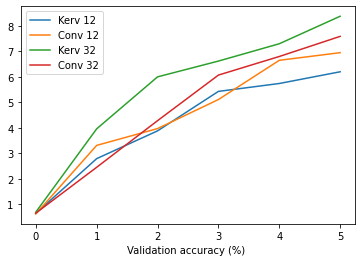

<Figure size 18000x36864 with 0 Axes>

In [ ]:

plt.plot(c1,label="Kerv 12 ")
plt.plot(c2,label="Conv 12")
plt.plot(c3, label="Kerv 32")
plt.plot(c4, label="Conv 32")
plt.legend()
plt.xlabel("Validation accuracy (%) ")
plt.figure(figsize=(250,512))

The results are promising,because we see that kervolutional networks converge more quickly than simple concolutional layers.
It is well known that deeper neural networks tend to find out more difficult relations and differences between classes.Here,a classic Lenet network using kernels in the convolution layers is evaluated.

In [ ]:
# Lenet networks with relu activation and pooling layers
modelLN = KervLeNet()
modelLN2 = ConvLeNet()

c11 = trainer(modelLN,optim.SGD(modelLN.parameters(),lr=1e-2))
c12 = trainer(modelLN2,optim.SGD(modelLN2.parameters(),lr=1e-2))

Iteration 0, loss = 6.6406
Got 40 / 10000 correct (0.40)

Iteration 100, loss = 5.3326
Got 110 / 10000 correct (1.10)

Iteration 200, loss = 5.2024
Got 158 / 10000 correct (1.58)

Iteration 300, loss = 5.1951
Got 174 / 10000 correct (1.74)

Iteration 400, loss = 5.1223
Got 183 / 10000 correct (1.83)

Iteration 500, loss = 5.1356
Got 239 / 10000 correct (2.39)

Iteration 0, loss = 7.9955
Got 53 / 10000 correct (0.53)

Iteration 100, loss = 5.2777
Got 102 / 10000 correct (1.02)

Iteration 200, loss = 5.2504
Got 143 / 10000 correct (1.43)

Iteration 300, loss = 5.2271
Got 156 / 10000 correct (1.56)

Iteration 400, loss = 5.1646
Got 176 / 10000 correct (1.76)

Iteration 500, loss = 5.1893
Got 231 / 10000 correct (2.31)



<Figure size 18000x36864 with 0 Axes>

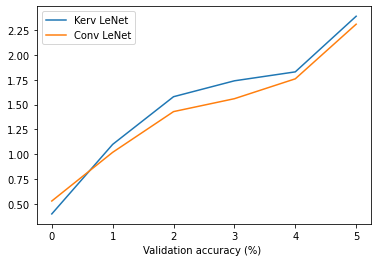

<Figure size 18000x36864 with 0 Axes>

In [ ]:
plt.plot(c11, label="Kerv LeNet")
plt.plot(c12, label="Conv LeNet")
plt.legend()
plt.xlabel("Validation accuracy (%) ")
plt.figure(figsize=(250,512))

LeNet also show faster convergence with kervolutional layer rather than a simple convolutional layer. \\
Let's continue our comparisons in the successful AlexNet 

In [ ]:
modelAlex = KervAlex()
modelAlex2 = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

c21 = trainer(modelAlex,optim.SGD(modelAlex.parameters(),lr=1e-2))
c22 = modelAlex2.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
plt.plot(c21, label="Kerv ALexNet")
plt.plot(c22, label="Conv AlexNet")
plt.legend()
plt.xlabel("Validation accuracy (%) ")
plt.figure(figsize=(250,512))

In the deeper networks,like AlexNet the diversity in convergence speed is even more obvious;as we see,kervolutional AlexNet achieves accuracy of 10% in half iterations than the original AlexNet. \\
Finally,the performance of polynomial kernels in the convolution process is going to be evaluated for one much deeper architecture,the popular VGG-16.

In [ ]:
modelVGG = KervVGG()
modelVGG2 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)

c31 = trainer(modelVGG,optim.SGG(modelVGG.parameters(),lr=1e-2))
c32 = modelVGG2.eval()

In [ ]:
plt.plot(c31, label="Kerv vgg16")
plt.plot(c32, label="Conv vgg16")
plt.legend()
plt.xlabel("Validation accuracy (%) ")
plt.figure(figsize=(250,512))

# **Part 2:Kervolution networks with and without ReLU**
Here,we are going to compare the impact of Relu non-linearity in to our kervolutional layers.We will make the same experiments in kervolution layers as before,but now we will compare kervolution networks with and without ReLu activations.


In [ ]:
#Stochastic gradient descent optimizer is going to be used,for all the network's training,with learning rate e-2
learning_rate = 1e-2

# Swallow networks with one convolution layer containing 12 3x3 filters 
modelA = TwoLayerKerv(12,3,200,False)
modelA2 = TwoLayerKerv(12,3,200)

# SWallow networks with one convolution layer containing 32 3x3 filters
modelB = TwoLayerKerv(32,3,200,False)
modelB2 = TwoLayerKerv(32,3,200)


print("Training process for kervolutional network with two layers and 12 filters")
c1 = trainer(modelA,optim.SGD(model.parameters(),lr=learning_rate))

print("Training process for convolutional network with two layers and 12 filters")
c2 = trainer(modelA2,optim.SGD(model2.parameters(),lr=learning_rate))

print("Training process for kervolutional network with two layers and 32 filters")
c3 = trainer(modelB,optim.SGD(model3.parameters(),lr=learning_rate))

print("Training process for convolutional network with two layers and 32 filters")
c4 = trainer(modelB2,optim.SGD(model4.parameters(),lr=learning_rate))

In [ ]:
plt.plot(c1, label="Kerv 16 no relu")
plt.plot(c2, label="Conv 16 relu")
plt.plot(c3, label="Kerv 32 no Relu")
plt.plot(c4, label="Kerv 32 relu")
plt.legend()
plt.xlabel("Validation accuracy (%) ")
plt.figure(figsize=(250,512))

As we see,rectified linear unit doesn't have any affect in the network when it uses polynomial kernel in its convolution layers.This means that we can remove them.

**Conclusion**
As it became clear from the exepriments,using polynomial kernels leads to faster convergence in all the popular CNN.Also,using the kernel trick guarantees non-linearity in the final hyperplane,so there is no need for activation function.In the experiments in Kervolutional networks with and without Relu there was no difference in accuracy and convergence. \\
Some interesting further investigation would consider other successful techniques used in neural networks and their impact in this specific type of convolutional networks using polynomial kernel,like batch normalization.